In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# -------------------------------
# Load cleaned datasets
# -------------------------------
resume_df = pd.read_csv("../data/original/resumes_cleaned.csv")
job_df    = pd.read_csv("../data/original/jobs_cleaned.csv")

resume_texts = resume_df["Resume_clean"].tolist()
job_texts    = job_df["job_text_clean"].tolist()

# -------------------------------
# Embedding models to test
# -------------------------------
embedding_models = {
    "multi_qa_mpnet": "multi-qa-mpnet-base-dot-v1",
    "all_mpnet": "all-mpnet-base-v2",
    "e5_large": "intfloat/e5-large-v2"
    "all-MiniLM": "all-MiniLM-L6-v2"
}

# -------------------------------
# Generate & save embeddings
# -------------------------------
for name, model_name in embedding_models.items():
    print(f"\nGenerating embeddings using: {model_name} ...")
    
    # Load model
    model = SentenceTransformer(model_name)
    
    # Resume embeddings
    resume_emb = model.encode(
        resume_texts,
        convert_to_numpy=True,
        show_progress_bar=True
    )
    
    # Job embeddings
    job_emb = model.encode(
        job_texts,
        convert_to_numpy=True,
        show_progress_bar=True
    )
    
    # L2 Normalization
    resume_emb = resume_emb / np.linalg.norm(resume_emb, axis=1, keepdims=True)
    job_emb    = job_emb    / np.linalg.norm(job_emb, axis=1, keepdims=True)
    
    # Save embeddings
    np.save(f"../data/embeddings/resume_emb_{name}.npy", resume_emb)
    np.save(f"../data/embeddings/job_emb_{name}.npy", job_emb)

    print(f"Saved: resume_emb_{name}.npy and job_emb_{name}.npy")



Generating embeddings using: multi-qa-mpnet-base-dot-v1 ...


Batches: 100%|██████████| 171/171 [13:44<00:00,  4.82s/it] 


Saved: resume_emb_multi_qa_mpnet.npy and job_emb_multi_qa_mpnet.npy

Generating embeddings using: all-mpnet-base-v2 ...


Batches: 100%|██████████| 171/171 [06:25<00:00,  2.25s/it]


Saved: resume_emb_all_mpnet.npy and job_emb_all_mpnet.npy

Generating embeddings using: intfloat/e5-large-v2 ...


Batches: 100%|██████████| 171/171 [24:49<00:00,  8.71s/it]


Saved: resume_emb_e5_large.npy and job_emb_e5_large.npy


In [13]:
import numpy as np

def load_emb(model_name):
    res = np.load(f"../data/embeddings/resume_emb_{model_name}.npy")
    job = np.load(f"../data/embeddings/job_emb_{model_name}.npy")
    return res, job

models = ["multi_qa_mpnet", "all_mpnet", "e5_large","all-MiniLM"]

embeddings = {m: load_emb(m) for m in models}


In [14]:
from sentence_transformers import util

def get_top_k(job_idx, resume_emb, job_emb, k=10):
    sims = util.cos_sim(job_emb[job_idx], resume_emb)[0].cpu().numpy()
    idx = sims.argsort()[::-1][:k]
    return idx, sims[idx]


In [15]:
testing_jobs = {
    "admin": 0,                        # Secretary / Office Helper
    "finance": 914,                    # Financial Analyst
    "tech": 78,                        # Java Senior Developer / Architect
    "education": 3,                    # Research Analyst or replace with English Teacher index
    "customer_service": 146,           # Administrative Assistant (customer-facing)
}


In [16]:
from sentence_transformers import util

# -------------------------------------
# Helper: print job posting
# -------------------------------------
def show_job_posting(job_idx, job_df, preview_chars=2000):
    print("\n" + "="*120)
    print(f"JOB POSTING #{job_idx}")
    print("="*120)
    
    if "Title" in job_df.columns:
        print(f"TITLE: {job_df.iloc[job_idx]['Title']}")
    if "Company" in job_df.columns:
        print(f"COMPANY: {job_df.iloc[job_idx]['Company']}")
    
    print("\n--- RAW JOB TEXT ---")
    if "job_text" in job_df.columns:
        print(job_df.iloc[job_idx]["job_text"][:preview_chars])
    
    print("\n--- CLEANED JOB TEXT ---")
    print(job_df.iloc[job_idx]["job_text_clean"][:preview_chars])
    
    print("="*120 + "\n")


# -------------------------------------
# Helper: print resumes in readable format
# -------------------------------------
def show_ranked_resumes(model_name, top_idx, scores, resume_df, k=10, preview_chars=800):
    print("\n" + "="*120)
    print(f"TOP {k} RESUMES — MODEL: {model_name}")
    print("="*120 + "\n")
    
    for rank, (idx, score) in enumerate(zip(top_idx, scores), start=1):
        print("-"*120)
        print(f"RANK {rank}")
        print(f"Row index:  {idx}")
        print(f"Resume ID:  {resume_df.iloc[idx]['ID']}")
        print(f"Score:      {score:.4f}")
        print("-"*120)
        print(resume_df.iloc[idx]["Resume_clean"][:preview_chars])
        print("-"*120 + "\n")


# -------------------------------------
# TESTING JOBS ARRAY (EDIT THIS)
# -------------------------------------
testing_jobs = {
    "admin": 0,           # Secretary / Office Helper
    "finance": 914,       # Financial Analyst
    "tech": 78,           # Java Senior Developer
    "education": 3,       # Research Analyst
    "customer_service": 146,  # Admin Assistant
}

# -------------------------------------
# MAIN LOOP: iterate through ALL test jobs
# -------------------------------------

models = ["multi_qa_mpnet", "all_mpnet", "e5_large"]

for domain, job_index in testing_jobs.items():

    print("\n" + "="*140)
    print(f"TESTING DOMAIN: {domain.upper()}  |  JOB INDEX: {job_index}")
    print("="*140)

    # Show this job posting
    show_job_posting(job_index, job_df)

    # Run all embedding models for this job
    for model_name in models:
        
        print(f"\nProcessing model: {model_name}")
        
        resume_emb = np.load(f"../data/embeddings/resume_emb_{model_name}.npy")
        job_emb    = np.load(f"../data/embeddings/job_emb_{model_name}.npy")
        
        scores_all = util.cos_sim(job_emb[job_index], resume_emb)[0].cpu().numpy()
        top_idx = scores_all.argsort()[::-1][:5]
        top_scores = scores_all[top_idx]
        
        show_ranked_resumes(model_name, top_idx, top_scores, resume_df)



TESTING DOMAIN: ADMIN  |  JOB INDEX: 0

JOB POSTING #0
TITLE: Secretary / office helper
COMPANY: LadyDalieda

--- RAW JOB TEXT ---
Description: Secretary office helper, Typing transitions from
English to Armenian, able to speck and understand English, Armenian and
Russian, to answer the phone and make calls, arrange appointments,
answering the door and welcoming in customers. Requirements: To take care of the office on there own some
times, work under there own supervision, be self motivated to keeping
the office in good order and file papers correctly. Have good
communication skills with customers by phone and in person. Qualifications: MS Word & Excel programs About Company: New Company starting up soon English school for
students.

--- CLEANED JOB TEXT ---
description secretary office helper typing transition english armenian able speck understand english armenian russian answer phone make call arrange appointment answering door welcoming customer requirement take care office time 

In [7]:
import numpy as np
import pandas as pd
from sentence_transformers import util
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split

# ---------------------------------------------------
# Load datasets
# ---------------------------------------------------
resume_emb = np.load("../data/embeddings/resume_emb_e5_large.npy")
job_emb    = np.load("../data/embeddings/job_emb_e5_large.npy")

resume_df = pd.read_csv("../data/original/resumes_cleaned.csv")
job_df    = pd.read_csv("../data/original/jobs_cleaned.csv")

# ---------------------------------------------------
# IMPORT FEATURE UTILITIES
# ---------------------------------------------------
from feature_extractors import (
    clean_text_for_domain,
    detect_domain,
    skill_match,
    education_score,
    seniority_score,
    keyword_overlap,
    DOMAIN_KEYWORDS,
    skills,
    education_levels,
    experience_words
)

# ---------------------------------------------------
# Hybrid scoring weights
# ---------------------------------------------------
weights = {
    'skills': 0.35,
    'experience': 0.20,
    'education': 0.15,
    'semantic': 0.15,
    'domain': 0.15
}

def compute_hybrid_score(cos_sim, skill_score, exp_score, edu_score, domain_score, weights):
    return (
        weights["semantic"]   * cos_sim +
        weights["skills"]     * skill_score +
        weights["experience"] * exp_score +
        weights["education"]  * edu_score +
        weights["domain"]     * domain_score
    )

# ---------------------------------------------------
# SPLIT JOBS INTO TRAIN / TEST FIRST  (IMPORTANT!)
# ---------------------------------------------------
train_jobs, test_jobs = train_test_split(
    job_df.index, test_size=0.15, random_state=42
)

print(f"Train Jobs: {len(train_jobs)}, Test Jobs: {len(test_jobs)}")


# ---------------------------------------------------
# FUNCTION TO GENERATE PAIRS FOR A SET OF JOBS
# ---------------------------------------------------
def generate_pairs(job_indices):
    rows = []

    for job_idx in tqdm(job_indices, desc="Generating pairs"):

        job_text_raw = job_df.iloc[job_idx]["job_text_clean"]
        job_text = clean_text_for_domain(job_text_raw)

        # Compute cosine similarity
        sims = util.cos_sim(job_emb[job_idx], resume_emb)[0].cpu().numpy()

        # Positive = Top 5
        pos_idx = sims.argsort()[::-1][:5]

        # Negative pool = bottom 70%
        cutoff = int(len(sims) * 0.7)
        neg_pool = sims.argsort()[:cutoff]
        neg_idx = random.sample(list(neg_pool), 20)

        # Build rows
        for r_idx, label in [(i, 1) for i in pos_idx] + [(i, 0) for i in neg_idx]:

            resume_text_raw = resume_df.iloc[r_idx]["Resume_clean"]
            resume_text = clean_text_for_domain(resume_text_raw)

            # Features
            kw_overlap_val = keyword_overlap(job_text, resume_text)
            skill_score_val = skill_match(job_text, resume_text)
            edu_score_val = education_score(resume_text)
            exp_score_val = seniority_score(resume_text)

            job_dom, _ = detect_domain(job_text)
            res_dom, _ = detect_domain(resume_text)
            domain_match = 1 if job_dom == res_dom else 0

            hybrid = compute_hybrid_score(
                sims[r_idx],
                skill_score_val,
                exp_score_val,
                edu_score_val,
                domain_match,
                weights
            )

            rows.append({
                "job_id": job_idx,
                "resume_id": r_idx,
                "cosine_sim": sims[r_idx],
                "keyword_overlap": kw_overlap_val,
                "skill_score": skill_score_val,
                "education_score": edu_score_val,
                "experience_score": exp_score_val,
                "domain_match": domain_match,
                "hybrid_score": hybrid,
                "label": label,
            })

    return pd.DataFrame(rows)


# ---------------------------------------------------
# GENERATE TRAIN & TEST SETS
# ---------------------------------------------------
print("\n=== Building TRAIN pairs ===")
train_df = generate_pairs(train_jobs)
train_df.to_csv("../data/train_pairs_rich.csv", index=False)
print("Saved → train_pairs_rich.csv")

print("\n=== Building TEST pairs ===")
test_df = generate_pairs(test_jobs)
test_df.to_csv("../data/test_pairs_rich.csv", index=False)
print("Saved → test_pairs_rich.csv")

print("\n ALL DONE ✔ Train + Test datasets created!")


Train Jobs: 4630, Test Jobs: 818

=== Building TRAIN pairs ===


Generating pairs: 100%|██████████| 4630/4630 [04:14<00:00, 18.19it/s]


Saved → train_pairs_rich.csv

=== Building TEST pairs ===


Generating pairs: 100%|██████████| 818/818 [00:44<00:00, 18.32it/s]


Saved → test_pairs_rich.csv

 ALL DONE ✔ Train + Test datasets created!


Loaded training pairs: (115750, 10)
Train size: (92600, 5) Val size: (23150, 5)

TRAINING LOGISTIC REGRESSION

LOGISTIC REGRESSION — DEFAULT THRESHOLD (0.5):

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     18520
           1       0.46      0.72      0.57      4630

    accuracy                           0.78     23150
   macro avg       0.69      0.76      0.71     23150
weighted avg       0.83      0.78      0.79     23150


=== HIGH-PRECISION REPORT (threshold=0.7) ===
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18520
           1       0.68      0.50      0.57      4630

    accuracy                           0.85     23150
   macro avg       0.78      0.72      0.74     23150
weighted avg       0.84      0.85      0.84     23150

Precision @ threshold 0.7: 0.6764
Saved logistic regression model → model_logreg.pkl

TRAINING RANDOM FOREST

RANDOM FOREST — DEFAULT THRESH

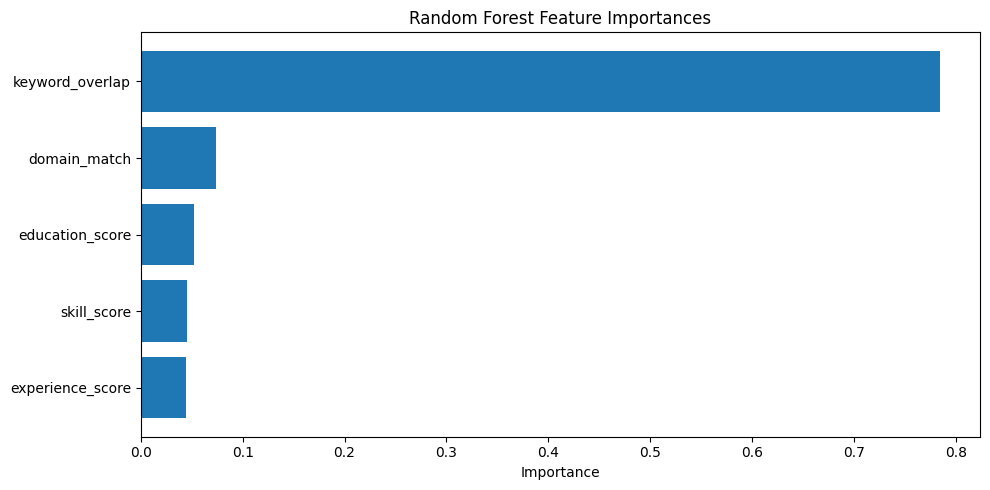

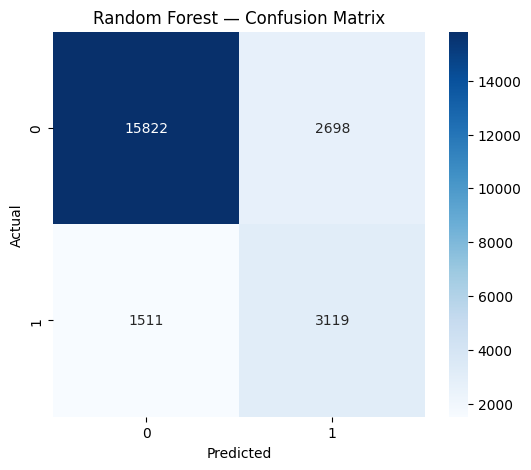


ALL DONE ✔ Precision-Optimized Models Trained!


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ============================================
# 1. LOAD TRAINING DATA
# ============================================
df = pd.read_csv("../data/train_pairs_rich.csv")
print("Loaded training pairs:", df.shape)

# ============================================
# 2. FEATURE SELECTION — MATCHES YOUR COLUMNS
# ============================================
FEATURES = [
    # "cosine_sim",
    "keyword_overlap",
    "skill_score",        # <--- FIXED NAME
    "experience_score",
    "education_score",
    "domain_match"
]

TARGET = "label"

X = df[FEATURES]
y = df[TARGET]

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Val size:", X_val.shape)

# ============================================
# Helper — Evaluate with HIGH PRECISION threshold
# ============================================
def evaluate_with_threshold(model, X, y, threshold=0.70):
    """
    Evaluates a classifier using a probability threshold instead of default 0.5.
    This increases precision (fewer false positives).
    """
    y_proba = model.predict_proba(X)[:, 1]
    y_pred_thr = (y_proba > threshold).astype(int)

    print(f"\n=== HIGH-PRECISION REPORT (threshold={threshold}) ===")
    print(classification_report(y, y_pred_thr))

    prec = precision_score(y, y_pred_thr, zero_division=0)
    print(f"Precision @ threshold {threshold}: {prec:.4f}")

    return y_pred_thr

# ============================================
# 3. BASELINE MODEL — LOGISTIC REGRESSION
# ============================================
print("\n==============================")
print("TRAINING LOGISTIC REGRESSION")
print("==============================")

logreg = LogisticRegression(max_iter=800, class_weight="balanced")
logreg.fit(X_train, y_train)

# Default evaluation (threshold = 0.5)
print("\nLOGISTIC REGRESSION — DEFAULT THRESHOLD (0.5):\n")
print(classification_report(y_val, logreg.predict(X_val)))

# High-precision evaluation
evaluate_with_threshold(logreg, X_val, y_val, threshold=0.70)

# Save model
joblib.dump(logreg, "../models/model_logreg.pkl")
print("Saved logistic regression model → model_logreg.pkl")

# ============================================
# 4. STRONG MODEL — RANDOM FOREST
# ============================================
print("\n==============================")
print("TRAINING RANDOM FOREST")
print("==============================")

rf = RandomForestClassifier(
    n_estimators=350,
    max_depth=14,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

print("\nRANDOM FOREST — DEFAULT THRESHOLD (0.5):\n")
print(classification_report(y_val, rf.predict(X_val)))

# High-precision evaluation
evaluate_with_threshold(rf, X_val, y_val, threshold=0.70)

# Save RF model
joblib.dump(rf, "../models/model_random_forest.pkl")
print("Saved random forest model → model_random_forest.pkl")

# ============================================
# 5. FEATURE IMPORTANCE PLOT
# ============================================
plt.figure(figsize=(10, 5))
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

plt.barh(np.array(FEATURES)[sorted_idx], importances[sorted_idx])
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ============================================
# 6. CONFUSION MATRIX (RF)
# ============================================
cm = confusion_matrix(y_val, rf.predict(X_val))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nALL DONE ✔ Precision-Optimized Models Trained!")


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import joblib
from tqdm import tqdm
import math

# ============================================================
# 1. LOAD TEST SET + MODELS
# ============================================================
test_df = pd.read_csv("../data/test_pairs_rich.csv")
print("Loaded test pairs:", test_df.shape)

# Load trained models
rf = joblib.load("../models/model_random_forest.pkl")
lr = joblib.load("../models/model_logreg.pkl")

# Choose which model to evaluate
model = lr   # <<--- switch to lr if you want

# Columns used for model input
FEATURES = [
    # "cosine_sim",
    "keyword_overlap",
    "skill_score",
    "experience_score",
    "education_score",
    "domain_match",
]

# ============================================================
# 2. CLASSIFICATION METRICS (threshold-based)
# ============================================================
print("\n===== CLASSIFICATION METRICS (threshold = 0.5) =====")
y_true = test_df["label"]
y_pred = model.predict(test_df[FEATURES])

print(classification_report(y_true, y_pred))

# ============================================================
# 3. FUNCTIONS FOR RANKING METRICS
# ============================================================

def precision_at_k(labels, k=10):
    """labels = list of 0/1 sorted in ranked order"""
    top_k = labels[:k]
    return sum(top_k) / k

def recall_at_k(labels, k=10):
    total_positives = sum(labels)
    if total_positives == 0:
        return 0
    return sum(labels[:k]) / total_positives

def average_precision(labels, k=10):
    """Compute AP@k"""
    num_hits = 0
    score = 0.0
    for i in range(k):
        if labels[i] == 1:
            num_hits += 1
            score += num_hits / (i + 1)
    return score / k

def ndcg_at_k(labels, k=10):
    """Normalized Discounted Cumulative Gain"""
    dcg = sum([
        (1 / math.log2(i + 2)) if labels[i] == 1 else 0
        for i in range(k)
    ])
    # Ideal DCG (all positives ranked first)
    ideal = sum([
        (1 / math.log2(i + 2))
        for i in range(min(sum(labels), k))
    ])
    return dcg / ideal if ideal > 0 else 0

# ============================================================
# 4. PER-JOB RANKED EVALUATION
# ============================================================
print("\n===== RANKING METRICS =====")

all_prec10 = []
all_rec10  = []
all_map10  = []
all_ndcg10 = []

for job_id, group in tqdm(test_df.groupby("job_id"), desc="Evaluating per-job"):

    # Predict probabilities
    probs = model.predict_proba(group[FEATURES])[:, 1]

    # Sort resumes by model probability (descending)
    group = group.copy()
    group["score"] = probs
    group = group.sort_values("score", ascending=False)

    labels_sorted = group["label"].tolist()

    # Ranking metrics
    p10 = precision_at_k(labels_sorted, k=10)
    r10 = recall_at_k(labels_sorted, k=10)
    ap10 = average_precision(labels_sorted, k=10)
    nd10 = ndcg_at_k(labels_sorted, k=10)

    all_prec10.append(p10)
    all_rec10.append(r10)
    all_map10.append(ap10)
    all_ndcg10.append(nd10)

# ============================================================
# 5. PRINT OVERALL RANKING PERFORMANCE
# ============================================================
print("\n===== FINAL RANKING PERFORMANCE (AVERAGED OVER JOBS) =====")

print(f"Precision@10 : {np.mean(all_prec10):.4f}")
print(f"Recall@10    : {np.mean(all_rec10):.4f}")
print(f"MAP@10       : {np.mean(all_map10):.4f}")
print(f"NDCG@10      : {np.mean(all_ndcg10):.4f}")

print("\nEvaluation complete ✔")


Loaded test pairs: (20450, 10)

===== CLASSIFICATION METRICS (threshold = 0.5) =====
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     16360
           1       0.47      0.75      0.58      4090

    accuracy                           0.78     20450
   macro avg       0.70      0.77      0.71     20450
weighted avg       0.83      0.78      0.80     20450


===== RANKING METRICS =====


Evaluating per-job: 100%|██████████| 818/818 [00:00<00:00, 1161.98it/s]


===== FINAL RANKING PERFORMANCE (AVERAGED OVER JOBS) =====
Precision@10 : 0.4399
Recall@10    : 0.8797
MAP@10       : 0.3722
NDCG@10      : 0.8404

Evaluation complete ✔


In [15]:
import numpy as np
import pandas as pd
from sentence_transformers import util

def rank_resumes_for_job(
    job_idx,
    model,
    test_df,
    resume_emb,
    job_emb,
    FEATURES,
    alpha=0.6
):
    """
    alpha = weight for ML probability (0–1)
    (1-alpha) = weight for cosine similarity
    """

    # Extract all rows for this job
    job_rows = test_df[test_df["job_id"] == job_idx].copy()

    # -----------------------------
    # 1. ML probability
    # -----------------------------
    ml_probs = model.predict_proba(job_rows[FEATURES])[:, 1]

    # -----------------------------
    # 2. Cosine similarity (safe)
    # -----------------------------
    sims = util.cos_sim(job_emb[job_idx], resume_emb)[0].cpu().numpy()

    # Align cosine similarities to resume_ids in job_rows
    resume_ids = job_rows["resume_id"].tolist()
    sims_aligned = np.array([sims[rid] for rid in resume_ids])

    # -----------------------------
    # 3. Final combined score
    # -----------------------------
    final_score = alpha * ml_probs + (1 - alpha) * sims_aligned

    job_rows["final_score"] = final_score
    job_rows = job_rows.sort_values("final_score", ascending=False)

    return job_rows


In [16]:
import math

def precision_at_k(labels, k=10):
    return sum(labels[:k]) / k

def recall_at_k(labels, k=10):
    total_pos = sum(labels)
    return sum(labels[:k]) / total_pos if total_pos > 0 else 0

def map_at_k(labels, k=10):
    hits = 0
    score = 0.0
    for i in range(k):
        if labels[i] == 1:
            hits += 1
            score += hits / (i + 1)
    return score / k

def ndcg_at_k(labels, k=10):
    dcg = sum([(1 / math.log2(i + 2)) if labels[i] == 1 else 0
               for i in range(k)])
    ideal = sum([(1 / math.log2(i + 2)) 
                 for i in range(min(sum(labels), k))])
    return dcg / ideal if ideal > 0 else 0


In [17]:
from tqdm import tqdm
import numpy as np

# Load data
test_df = pd.read_csv("../data/test_pairs_rich.csv")
rf = joblib.load("../models/model_random_forest.pkl")
lr = joblib.load("../models/model_logreg.pkl")

model = lr   # <--- choose model

FEATURES = [
    "keyword_overlap",
    "skill_score",
    "experience_score",
    "education_score",
    "domain_match",
]

job_ids = test_df["job_id"].unique()

# Store results
all_p10, all_r10, all_map10, all_ndcg10 = [], [], [], []

alpha = 0.6  # weighting for ML model

for job_id in tqdm(job_ids, desc="Evaluating jobs"):

    ranked_df = rank_resumes_for_job(
        job_idx=job_id,
        model=model,
        test_df=test_df,
        resume_emb=resume_emb,
        job_emb=job_emb,
        FEATURES=FEATURES,
        alpha=alpha
    )

    labels_sorted = ranked_df["label"].tolist()

    all_p10.append(precision_at_k(labels_sorted, 10))
    all_r10.append(recall_at_k(labels_sorted, 10))
    all_map10.append(map_at_k(labels_sorted, 10))
    all_ndcg10.append(ndcg_at_k(labels_sorted, 10))

# Print results
print("\n===== SAFE COMBINED MODEL PERFORMANCE =====")
print(f"Precision@10 : {np.mean(all_p10):.4f}")
print(f"Recall@10    : {np.mean(all_r10):.4f}")
print(f"MAP@10       : {np.mean(all_map10):.4f}")
print(f"NDCG@10      : {np.mean(all_ndcg10):.4f}")


Evaluating jobs: 100%|██████████| 818/818 [00:02<00:00, 274.51it/s]


===== SAFE COMBINED MODEL PERFORMANCE =====
Precision@10 : 0.4517
Recall@10    : 0.9034
MAP@10       : 0.3911
NDCG@10      : 0.8688
